In [1]:
import numpy as np
from sympy.physics.wigner import wigner_3j,wigner_6j
import sympy as sy
from numpy import linalg as LA
from IPython.display import Latex,display
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
sns.set_palette('terrain')
from Energy_Levels import MoleculeLevels
np.set_printoptions(precision=5, suppress=True)
%matplotlib qt

In [202]:
import matrix_elements as me
kronecker = me.kronecker
from functools import partial

def build_operator(q_in,q_out,matrix_element,symbolic=False):
    q_str_in = list(q_in)
    q_str_out = list(q_out)
    size_in = len(q_in[q_str_in[0]])
    size_out = len(q_out[q_str_out[0]])
    operator = np.zeros((size_out,size_in))
    for i in range(size_out):
        for j in range(size_in):
            state_out = {q+'0':q_out[q][i] for q in q_out}
            state_in = {q+'1':q_in[q][j] for q in q_in}
            q_args = {**state_out,**state_in}
            operator[i,j] = matrix_element(**q_args)
            if symbolic:
                operator[i,j] = sy.nsimplify(operator[i,j])
    if symbolic:
        operator = sy.Matrix(operator)
    return operator

def decouple_b(input_qnumbers,output_qnumbers,S=1/2,I=1/2):
    input_keys = list(input_qnumbers)
    output_keys = list(output_qnumbers)
    input_size = len(input_qnumbers[input_keys[0]])
    output_size = len(output_qnumbers[output_keys[0]])
    basis_matrix = np.zeros((output_size,input_size)).tolist()
    for i in range(output_size):
        for j in range(input_size):
            decoupled_qnumbers = {q:output_qnumbers[q][i] for q in output_keys}
            b_qnumbers = {q:input_qnumbers[q][j] for q in input_keys}
            basis_matrix[i][j] = sy.nsimplify(decouple_b_even(decoupled_qnumbers,b_qnumbers,S=S,I=I))
    return basis_matrix

B,gamma,gammap, bF,c,b,q_lD,muE,muB,g_S,g_L = sy.symbols('B_{rot} gamma gamma^\' b_F c b q_{lD} D mu_B g_S g_L')
params_40X010 = {
'Be': B,
'Gamma_SR': gamma,
'Gamma_Prime': gammap,
'bF': 0,
'c': 0,
'b': b,
'q_lD': q_lD,
'muE': muE,
'mu_B': muB, #MHz/Gauss
'g_S': g_S,
'g_L': g_L,
}

bBJ_even_X_matrix_elements={
# Fine Structure
'N^2': me.Rot_bBJ,                 # N^2 Rotation
'N.S': me.SR_bBJ,                  # N.S Spin Rotation
'l-doubling': me.lD_bBJ,           # Effective l doubling
'l doubling p':me.p_lD_bBJ,
'l doubling q':me.q_lD_bBJ,
'NzSz': me.NzSz_bBJ,               # NzSz for bending mode

# Hydrogen Hyperfine
'I.S': me.IS_bBJ,                  # I.S Fermi Contact Interaction
'T2_0(I,S)': me.T2IS_bBJ,          # I S dipolar interaction
'Iz': me.Iz_bBJ,                   # I.n projection of I on internuclear axis n
'Sz': me.Sz_bBJ,                   # S.n projection of S on internuclear axis n
}

def Parity_b(K0,N0,J0,F0,M0,K1,N1,J1,F1,M1,S=1/2,I=1/2):
    if not kronecker(N0,N1)*kronecker(M0,M1)*kronecker(J0,J1)*kronecker(F0,F1):
        return 0
    elif K1!=-K0:
        return 0
    else:
        return (-1)**(N0-abs(K0))
    
def Parity_a(K0,Sigma0,P0,J0,F0,M0,K1,Sigma1,P1,J1,F1,M1,S=1/2,I=1/2):
    return (-1)**(J0-S-abs(K0))*kronecker(K0,-K1)*kronecker(Sigma0,-Sigma1)*kronecker(P0,-P1)*kronecker(J0,J1)*kronecker(F0,F1)*kronecker(M0,M1)
    
def convert_abBJ(input_qnumbers,output_qnumbers,S=1/2,sym=True):
    input_keys = list(input_qnumbers)
    output_keys = list(output_qnumbers)
    input_size = len(input_qnumbers[input_keys[0]])
    output_size = len(output_qnumbers[output_keys[0]])
    basis_matrix = np.zeros((output_size,input_size))
    for i in range(output_size):
        for j in range(input_size):
            if 'N' in input_keys: #Convert case (b) to (a)
                a_qnumbers = {q:output_qnumbers[q][i] for q in output_keys}
                b_qnumbers = {q:input_qnumbers[q][j] for q in input_keys}
            else:
                b_qnumbers = {q:output_qnumbers[q][i] for q in output_keys}
                a_qnumbers = {q:input_qnumbers[q][j] for q in input_keys}
            basis_matrix[i,j] = b2a_matrix(a_qnumbers,b_qnumbers,S=S)
    if sym:        
        basis_matrix = sy.Matrix(basis_matrix)
    return basis_matrix

def b2a_matrix(a,b,S=1/2):
    if not kronecker(a['K'],b['K'])*kronecker(a['J'],b['J'])*kronecker(a['F'],b['F'])*kronecker(a['M'],b['M']):
        return 0
    else:
        if 'F1' in b.keys():
            if not kronecker(a['F1'],b['F1']):
                return 0
        return (-1)**(b['N']-S+a['P'])*np.sqrt(2*b['N']+1)*wigner_3j(a['J'],S,b['N'],a['P'],-a['Sigma'],-a['K'])
    
def TDM_noM(K0,Sigma0,P0,J0,F0,M0,K1,Sigma1,P1,J1,F1,M1,S=1/2,I=1/2):
    if not kronecker(Sigma0,Sigma1):
        return 0
    elif not (kronecker(F0,F1) or kronecker(F0+1,F1) or kronecker(F0-1,F1)):
        return 0
    else:
        TDM_total = 1/np.sqrt((2*F1+1))*sum([
                        (-1)**(F1+J0+I+1)*sy.sqrt((2*F0+1)*(2*F1+1))*\
                            wigner_6j(J1,F1,I,F0,J0,1)*(-1)**(J0-P0)*sy.sqrt((2*J0+1)*(2*J1+1))*wigner_3j(J0,1,J1,-P0,q,P1)\
                            for q in range(-1,2)])
        return sy.nsimplify(TDM_total)

In [92]:
def TDM_b(K0,N0,J0,F0,M0,K1,N1,J1,F1,M1,S=1/2,sym=False):
    if sym:
        return (sy.nsimplify(1/(sy.sqrt(2*J1+1))*(-1)**(J1+N1+1+S)*sy.sqrt((2*J0+1)*(2*J1+1))*wigner_6j(N1,J1,S,J0,N0,1)*(-1)**(N0-K0)*wigner_3j(N0,1,N1,-K0,0,K1)))**2
    else:
        return (1/(np.sqrt(2*J1+1))*(-1)**(J1+N1+1+S)*np.sqrt((2*J0+1)*(2*J1+1))*wigner_6j(N1,J1,S,J0,N0,1)*(-1)**(N0-K0)*wigner_3j(N0,1,N1,-K0,0,K1))**2


In [93]:
def q_numbers_even_bBJ(N_range,K_mag,S=1/2,I_list=[0,1/2],M_values='all',M_range=[]):
    IM=I_list[0]
    iH = I_list[-1]
    Nmin,Nmax=N_range[0],N_range[-1]
    K_mag = abs(K_mag)
    if Nmin<K_mag:
        print('Nmin must be >= |K|')
        Nmin=abs(K_mag)
    q_str = ['K','N','J','F','M']
    I = max(IM,iH)
    q_numbers = {}
    for q in q_str:
        q_numbers[q] = []
    for N in np.arange(Nmin,Nmax+1,1):
        for J in np.arange(abs(N-S),abs(N+S)+1,1):
            for F in np.arange(abs(J-I),abs(J+I)+1,1):
                if M_values=='none':
                    for K in {True:[0], False:[-K_mag,K_mag]}[K_mag==0]:
                        M=abs(F)%1
                        values = [K,N,J,F,M]
                        for q,val in zip(q_str,values):
                            q_numbers[q].append(val+0)    #looks weird but adding 0 converts -0 to 0
                else:
                    if M_values=='all' or M_values=='custom':
                        Mmin = -F
                    elif M_values=='pos':
                        Mmin = abs(F) % 1
                    for M in np.arange(Mmin,F+1,1):
                        if (M_values=='custom' and M in M_range) or (M_values=='all') or (M_values=='pos'):
                            for K in {True:[0], False:[-K_mag,K_mag]}[K_mag==0]:
                                values = [K,N,J,F,M]
                                for q,val in zip(q_str,values):
                                    q_numbers[q].append(val+0)    #looks weird but adding 0 converts -0 to 0
                        elif M_values=='custom' and M not in M_range:
                            continue
    return q_numbers

def q_numbers_even_aBJ(N_range,K_mag=1,S=1/2,I_list=[0,1/2],M_values='all',P_values=[1/2],M_range=[]):
    IM=I_list[0]
    iH = I_list[-1]
    Nmin,Nmax=N_range[0],N_range[-1]
    Jmin = abs(Nmin-S)
    Jmax = abs(Nmax+S)
    K_mag = abs(K_mag)
    if Nmin<K_mag:
        print('Nmin must be >= |K|')
        Nmin=abs(K_mag)
    q_str = ['K','Sigma','P','J','F','M']
    q_numbers = {}
    for q in q_str:
        q_numbers[q] = []
    I = max(IM,iH)
    for J in np.arange(Jmin,Jmax+1,1):
        for F in np.arange(abs(J-I),abs(J+I)+1,1):
            if M_values=='none':
                for Sigma in np.arange(-abs(S),abs(S)+1,1):
                    for K in {True:[0], False:[-K_mag,K_mag]}[K_mag==0]:
                        P=K+Sigma
                        if abs(P) not in P_values:
                            continue
                        elif J < abs(P):
                            continue
                        else:
                            M=abs(F)%1
                            values = [K,Sigma,P,J,F,M]
                        for q,val in zip(q_str,values):
                            q_numbers[q].append(val+0)    #looks weird but adding 0 converts -0 to 0
            else:
                if M_values=='all' or M_values=='custom':
                    Mmin = -F
                elif M_values=='pos':
                    Mmin = abs(F) % 1
                for M in np.arange(Mmin,F+1,1):
                    if (M_values=='custom' and M in M_range) or (M_values=='all') or (M_values=='pos'):
                        for Sigma in np.arange(-abs(S),abs(S)+1,1):
                            for K in {True:[0], False:[-K_mag,K_mag]}[K_mag==0]:
                                P=K+Sigma
                                if abs(P) not in P_values:
                                    continue
                                elif J < abs(P):
                                    continue
                                else:
                                    values = [K,Sigma,P,J,F,M]
                                for q,val in zip(q_str,values):
                                    q_numbers[q].append(val+0)    #looks weird but adding 0 converts -0 to 0
                    elif M_values=='custom' and M not in M_range:
                        continue
    return q_numbers

In [317]:
qa_X010 = q_numbers_even_aBJ([1,2,3],1,I_list=[0,0],M_values='none')
qa_B010 = q_numbers_even_aBJ([1,2,3],1,I_list=[0,0],M_values='none')

In [318]:
qb_X010 = q_numbers_even_bBJ([1,2,3],1,I_list=[0,0],M_values='none')
qb_B010 = q_numbers_even_bBJ([1,2,3],1,I_list=[0,0],M_values='none')

In [319]:
TDM = build_operator(qa_X010,qa_B010,partial(TDM_noM,I=0))
Pa = build_operator(qa_X010,qa_X010,Parity_a,symbolic=True)
Pb = build_operator(qb_X010,qb_X010,Parity_b,symbolic=True)

In [320]:
b2a = convert_abBJ(qb_X010,qa_X010)
b2a = np.array(b2a).astype(np.float64)

In [321]:
TDM = np.array(TDM).astype(np.float64)

In [322]:
qa_X010

{'K': [1, -1, 1, -1, 1, -1, 1, -1],
 'Sigma': [-0.5, 0.5, -0.5, 0.5, -0.5, 0.5, -0.5, 0.5],
 'P': [0.5, -0.5, 0.5, -0.5, 0.5, -0.5, 0.5, -0.5],
 'J': [0.5, 0.5, 1.5, 1.5, 2.5, 2.5, 3.5, 3.5],
 'F': [0.5, 0.5, 1.5, 1.5, 2.5, 2.5, 3.5, 3.5],
 'M': [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]}

In [323]:
Pamat, parities_a = [np.array(out).astype(np.float64) for out in Pa.diagonalize()]
Pbmat, parities_b = [np.array(out).astype(np.float64) for out in Pb.diagonalize()]

In [324]:
Painv = (np.linalg.inv(Pamat))
Pbinv = (np.linalg.inv(Pbmat))

In [330]:
b2a_parity_BR=(Pbinv@b2a.T@TDM@b2a@Pbmat)**2

In [331]:
pa_val = np.diag(parities_a)
pb_val = np.diag(parities_b)

In [332]:
BR_plot.shape

(12, 8)

In [333]:
'\u2119'

'ℙ'

In [334]:
qa_X010['Par']=pa_val
qb_X010['Par']=pb_val

In [328]:
[', '.join([(k+'={}'.format(v[i])) for k,v in qa_X010.items() if (k=='J' or k=='N' or k=='Par')]) for i in range(10)][0]

IndexError: list index out of range

In [336]:
fig,ax = plt.subplots(figsize=(10,10),constrained_layout=True)
BR_plot = b2a_parity_BR
log=False
if log:
    BR_plot=np.log10(BR0)
    vmin = -10
    vmax = 0
else:
    vmin=None
    vmax = None
#     log_BR = np.copy(BR0)
#     for i,val1 in enumerate(log_BR):
#         for j,val2 in enumerate(val1):
#             if val2 !=0:
#                 log_BR[i,j] = np.log10(val2)
#     BR_plot = log_BR
mat = ax.matshow(BR_plot,cmap=plt.get_cmap('hot'),vmax = vmax, vmin = 0)
y,x = BR_plot.shape
ax.set_yticks(np.arange(0,y))
ax.set_xticks(np.arange(0,x))
y_labels = [', '.join([(k+'={}'.format(v[i])) for k,v in qb_X010.items() if (k=='J' or k=='N' or k=='Par')]) for i in range(y)]
x_labels = [', '.join([(k+'={}'.format(v[i])) for k,v in qb_X010.items() if (k=='J' or k=='N' or k=='Par')]) for i in range(x)]
ax.set_yticklabels(y_labels, rotation='40', fontsize=12, ha='right')
ax.set_xticklabels(x_labels, rotation='40', fontsize=12,ha='left')
ax.tick_params(axis='both',labelsize=14,direction='out')
ax.grid(True,which='major',color='white',ls='--',linewidth=0.5)
ax.grid(False,which='minor')
(bot,top) = ax.get_ylim()
# ax.set_ylim(bot+0.5, top-0.5)
cbar = fig.colorbar(mat, ax=ax,fraction=0.015, pad=0.05)
#ax.set_xlim(-0.5,x.size+0.5);

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


In [255]:
y_labels = list(qb_X010.items())

In [256]:
y_labels

[('K', [-1, 1, -1, 1, -1, 1, -1, 1]),
 ('N', [1, 1, 1, 1, 2, 2, 2, 2]),
 ('J', [0.5, 0.5, 1.5, 1.5, 1.5, 1.5, 2.5, 2.5]),
 ('F', [0.5, 0.5, 1.5, 1.5, 1.5, 1.5, 2.5, 2.5]),
 ('M', [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])]

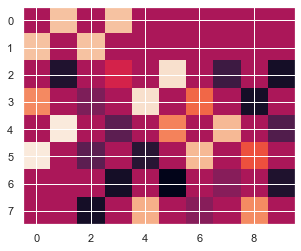

In [236]:
plt.imshow(b2a_parity_BR)

In [ ]:


M_values='none'
iH=0

if M_values != 'none':
    ext_fields = {
    # External Fields
    'ZeemanZ': me.ZeemanZ_bBJ,         # Zeeman interaction with lab z magnetic field
    'StarkZ': me.StarkZ_bBJ            # Stark interaction with lab z electric field
    }
    bBJ_even_X_matrix_elements.update(ext_fields)
for term,element in bBJ_even_X_matrix_elements.items():       #iterate through, substitute hydrogen proton value
    bBJ_even_X_matrix_elements[term] = partial(element,I=iH)

In [14]:
X010 = MoleculeLevels.initialize_state('CaOH','40','X010',[1,2,3],M_values = 'none',I=[0,0],S=1/2,round=8)
op = partial(build_operator,X010.q_numbers,X010.q_numbers,symbolic=True)

Cannot construct decoupled basis without M values


In [5]:
P = op(Parity)

In [6]:
lD = op(bBJ_even_X_matrix_elements['l doubling q'])*q_lD

In [7]:
lD_eff = lD = op(bBJ_even_X_matrix_elements['l-doubling'])*q_lD

In [8]:
lD_eff

Matrix([
[          0, -2.0*q_{lD},           0,           0],
[-2.0*q_{lD},           0,           0,           0],
[          0,           0,           0, -2.0*q_{lD}],
[          0,           0, -2.0*q_{lD},           0]])

In [9]:
lD

Matrix([
[          0, -2.0*q_{lD},           0,           0],
[-2.0*q_{lD},           0,           0,           0],
[          0,           0,           0, -2.0*q_{lD}],
[          0,           0, -2.0*q_{lD},           0]])

In [45]:
vec = X010.evecs0()

-sqrt(2)/2